In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import math
import torch
from torch.utils import model_zoo
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


In [3]:
data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


In [4]:
train_x, val_x = torch.from_numpy(train_x).float(), torch.from_numpy(val_x).float()
train_y, val_y = torch.from_numpy(train_y).float(), torch.from_numpy(val_y).float()

# Convert data format from channel_last to channer_first
N, L, C = train_x.shape
n, l, _ = val_x.shape
train_x = train_x.reshape(N, C, L)
val_x = val_x.reshape(n, C, l)

# Generate dataset for data loader
train_dataset = data.TensorDataset(train_x, train_y)
val_dataset = data.TensorDataset(val_x, val_y)

In [43]:
# Reference for connecting Conv1D and LSTM: https://mxnet.incubator.apache.org/versions/master/tutorials/basic/reshape_transpose.html
class HybridNet(nn.Module):
    
    def __init__(self, pesudo_input, num_filters, filter_size, rnn_size, fc_out, dp1, dp2, 
                 num_rnn_layers=1, rnn_dropout=0):
        super(HybridNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=num_filters, kernel_size=filter_size)
        out = self.conv1(pesudo_input)
        out = nn.MaxPool1d(kernel_size=5, stride=5)(out)
        ####################################################
        print('shape after conv1d {}'.format(out.shape))
        N, C, T = out.shape
        out = torch.transpose(out, 1, 2)
        print('shape before lstm {}'.format(out.shape))
        ####################################################
        # or input_size*seq_len
        self.bi_lstm = nn.LSTM(input_size=C, hidden_size=rnn_size, num_layers=num_rnn_layers,
                              batch_first=True, dropout=rnn_dropout, bidirectional=True)
        out, _ = self.bi_lstm(out)
        print('shape after lstm {}'.format(out.shape))
        N, T, C = out.shape
        out = torch.transpose(out, 1, 2)
        out = out.reshape(N, -1)
        print('shape after flattening {}'.format(out.shape))
        self.fc1 = nn.Linear(T*C, fc_out, bias=True)
        self.fc2 = nn.Linear(fc_out, 1)
        self.p1 = dp1
        self.p2 = dp2
        
    def forward(self, seq):
        self.activation_seq = F.relu(self.conv1(seq))
        out = nn.MaxPool1d(kernel_size=5, stride=5)(self.activation_seq)
        out = nn.Dropout(p=self.p1)(out)
        
        #################################################################################
        # Input of LSTM layer should have shape (sequence_length, batch_size, input_size)
        #     - Sequence length here should be the length of activation after downsampling
        #     - Input size should be the number of filters
        #################################################################################
        N, C, T = out.shape
#         out = out.view(bs, 1, -1)
        out = torch.transpose(out, 1, 2)
        out, _ = self.bi_lstm(out)
        out = F.relu(out)
        
        #################################################################################
        # Need to flatten the sequence before feeding them into fully connected layer
        #################################################################################
        N, T, C = out.shape
        out = torch.transpose(out, 1, 2)
        out = out.reshape(N, -1)
        out = nn.Dropout(p=self.p2)(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.squeeze(out)
        return nn.Sigmoid()(out)

In [61]:
batch_size = 256
pesudo_input = torch.rand(batch_size, C, L, dtype=train_x.dtype)
hybrid_net = HybridNet(pesudo_input,
                       num_filters=15, 
                       filter_size=10, 
                       rnn_size=10, 
                       fc_out=20, 
                       dp1=0.6, dp2=0.7).to(device)

shape after conv1d torch.Size([256, 15, 201])
shape before lstm torch.Size([256, 201, 15])
shape after lstm torch.Size([256, 201, 20])
shape after flattening torch.Size([256, 4020])


In [62]:
hybrid_net

HybridNet(
  (conv1): Conv1d(4, 15, kernel_size=(10,), stride=(1,))
  (bi_lstm): LSTM(15, 10, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=4020, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [63]:
4*15*10 + 15 + 2*(15*10 + 10*10) + (4020*20 + 20)

81535

In [64]:
optimizers = {'adam': torch.optim.Adam(hybrid_net.parameters(), lr=1e-3),
              'rmsprop': torch.optim.RMSprop(hybrid_net.parameters(), lr=1e-4, weight_decay=1e-5)}
config = {'epochs':150, 'device':device, 
          'opt': optimizers['rmsprop'],
          'criterion':nn.BCELoss(),
          'batch_size': batch_size,
          'log_interval':1}
C, L = train_x[0].shape

In [65]:
def train(model, train_dataset, val_dataset, config):
    # Unpack config
    epochs = config['epochs']
    device = config['device']
    optimizer = config['opt']
    criterion = config['criterion']
    log_interval = config['log_interval']
    batch_size = config['batch_size']
    
    def get_acc(y_hat, y):
        y_pred = np.where(y_hat >=0.5, 1, 0)
        return np.mean(y_pred == y)
    
    # Generate data loaders
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
    total_train_steps = len(train_loader)
    total_val_steps = len(val_loader)
    
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    print("Train on {} samples, validate on {} samples".format(len(train_dataset), len(val_dataset)))
    # Start training
    for epoch in range(1, epochs+1):
        train_loss_sum, train_acc_sum = 0, 0
        tic = time.time()
        for i, (batch, labels) in enumerate(train_loader):
            # Transfer data to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            # Forward pass and calculating loss
            y_hat = model(batch)
            loss = criterion(y_hat, labels)
            
            # Backward pass and updating weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            train_acc_sum += get_acc(y_hat.cpu().detach().numpy(), labels.cpu().detach().numpy())
        tac = time.time()
        avg_train_loss = train_loss_sum/total_train_steps
        avg_train_acc = train_acc_sum/total_train_steps
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        print('***************************************')
        print('Epoch {}: training loss {}, training acc {}'.format(epoch, avg_train_loss, avg_train_acc))
        print('Time: {} \n'.format(tac-tic))
        
        # Validation
        if epoch % log_interval == 0 or epoch == epochs:
            with torch.no_grad():
                val_loss_sum, val_acc_sum = 0, 0
                for j, (batch, labels) in enumerate(val_loader):
                    batch, labels = batch.to(device), labels.to(device)
                    y_hat = model(batch)
                    loss = criterion(y_hat, labels)
                    val_loss_sum += loss.item()
                    val_acc_sum += get_acc(y_hat.cpu().detach().numpy(), labels.cpu().detach().numpy())
                avg_val_loss = val_loss_sum/total_val_steps
                avg_val_acc = val_acc_sum/total_val_steps
                val_loss_list.append(avg_val_loss)
                val_acc_list.append(avg_val_acc)
                print('[Validation loss {}, validation acc {}] \n'.format(avg_val_loss, avg_val_acc))
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [66]:
hybrid_net, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(hybrid_net, train_dataset, val_dataset, config)

Train on 4013 samples, validate on 1003 samples
***************************************
Epoch 1: training loss 0.6947806887328625, training acc 0.5204753544978323
Time: 0.6473979949951172 

[Validation loss 0.6928386241197586, validation acc 0.5102809175531915] 

***************************************
Epoch 2: training loss 0.6926883794367313, training acc 0.5204753544978323
Time: 0.5421645641326904 

[Validation loss 0.6931778639554977, validation acc 0.5102809175531915] 

***************************************
Epoch 3: training loss 0.6922972574830055, training acc 0.5204753544978323
Time: 0.5463974475860596 

[Validation loss 0.6929638385772705, validation acc 0.5102809175531915] 

***************************************
Epoch 4: training loss 0.6923835724592209, training acc 0.5204753544978323
Time: 0.5409517288208008 

[Validation loss 0.6932851672172546, validation acc 0.5102809175531915] 

***************************************
Epoch 5: training loss 0.6925542242825031, train

***************************************
Epoch 39: training loss 0.6734684891998768, training acc 0.5256488777998555
Time: 0.5381894111633301 

[Validation loss 0.6698205471038818, validation acc 0.5634516289893617] 

***************************************
Epoch 40: training loss 0.6725282110273838, training acc 0.5356685219472543
Time: 0.5359530448913574 

[Validation loss 0.6741794496774673, validation acc 0.5227144281914894] 

***************************************
Epoch 41: training loss 0.6724193133413792, training acc 0.5248769418352601
Time: 0.5342934131622314 

[Validation loss 0.6683493703603745, validation acc 0.5569813829787233] 

***************************************
Epoch 42: training loss 0.6722007095813751, training acc 0.5265379448157514
Time: 0.5404036045074463 

[Validation loss 0.6681524813175201, validation acc 0.5731299867021277] 

***************************************
Epoch 43: training loss 0.6727112866938114, training acc 0.5245057916365607
Time: 0.53394579

***************************************
Epoch 77: training loss 0.6692174412310123, training acc 0.5318497674313584
Time: 0.5401697158813477 

[Validation loss 0.6672829836606979, validation acc 0.5341713763297873] 

***************************************
Epoch 78: training loss 0.6701400317251682, training acc 0.5272012170339595
Time: 0.5399665832519531 

[Validation loss 0.6668673753738403, validation acc 0.5451919880319149] 

***************************************
Epoch 79: training loss 0.6689374521374702, training acc 0.534495800216763
Time: 0.5404090881347656 

[Validation loss 0.6653145104646683, validation acc 0.5397689494680851] 

***************************************
Epoch 80: training loss 0.6685939878225327, training acc 0.5360876535404624
Time: 0.5422320365905762 

[Validation loss 0.6677950918674469, validation acc 0.5523603723404256] 

***************************************
Epoch 81: training loss 0.6700280904769897, training acc 0.5413416162391619
Time: 0.533238172

***************************************
Epoch 115: training loss 0.6677686870098114, training acc 0.5355894937680636
Time: 0.5386905670166016 

[Validation loss 0.6660429537296295, validation acc 0.5566323138297873] 

***************************************
Epoch 116: training loss 0.667092103511095, training acc 0.5368101968930636
Time: 0.5345072746276855 

[Validation loss 0.6652862727642059, validation acc 0.557259807180851] 

***************************************
Epoch 117: training loss 0.6667012423276901, training acc 0.548900097091763
Time: 0.5417633056640625 

[Validation loss 0.6651738584041595, validation acc 0.534798869680851] 

***************************************
Epoch 118: training loss 0.6677177175879478, training acc 0.5402775582550579
Time: 0.562964677810669 

[Validation loss 0.6660828739404678, validation acc 0.5481923204787233] 

***************************************
Epoch 119: training loss 0.666929118335247, training acc 0.541907514450867
Time: 0.5395588874

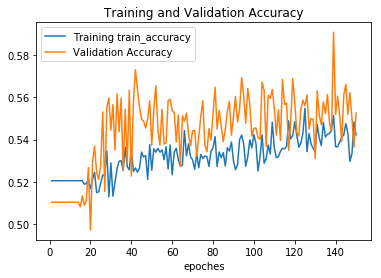

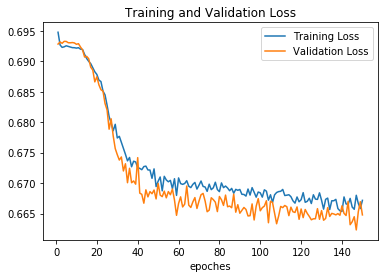

In [67]:
log_interval = 1
dianostic_plots(train_acc_list[::log_interval], train_loss_list[::log_interval], val_acc_list, val_loss_list)

In [51]:
# Reference: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
model_parameters = filter(lambda p: p.requires_grad, hybrid_net.parameters())
params = sum([np.prod(p.size()) for p in hybrid_net.parameters()])
print('The total number of trainable parameters is {}.'.format(params))

The total number of trainable parameters is 83216.


In [74]:
for p in hybrid_net.parameters():
    if p.requires_grad:
        print(p.shape)

torch.Size([15, 4, 10])
torch.Size([15])
torch.Size([40, 201])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([40, 201])
torch.Size([40, 10])
torch.Size([40])
torch.Size([40])
torch.Size([20, 300])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])
